In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q keras

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
# Import
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Activation, Lambda, Subtract, concatenate
from tensorflow.keras.layers import Add
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.models import Sequential


In [ ]:
print('We are using {} GPUs'.format(len(tf.config.list_physical_devices('GPU'))))

We are using 1 GPUs


In [ ]:
# Loading Datasets
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('The shape of train data is {}, \n and the test data is {}'.format
      (x_train.shape, x_test.shape))
input_shape = x_train.shape[1:]

# Normalization
x_train, x_test = x_train/255.0, x_test/255.0

170498071/170498071 [==============================] - 2s 0us/step
The shape of train data is (50000, 32, 32, 3), 
 and the test data is (10000, 32, 32, 3)


In [ ]:
def rdb_block(inputs, numLayers):
  channels = inputs.get_shape()[-1]
  storedOutputs = [inputs]
  for _ in range(numLayers):
    localConcat = tf.concat(storedOutputs, axis=-1)
    out = Conv2D(filters=channels, kernel_size=3, padding="same",
                 activation="relu")(localConcat)
    storedOutputs.append(out)
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = Conv2D(filters=inputs.get_shape()[-1], kernel_size=1,
                     padding="same", activation="relu")(finalConcat)
  finalOut = Add()([finalOut, inputs])
  return finalOut


In [ ]:
rdbLayers=3
def BRDNet(input_shape = input_shape, epsilon=1e-3, axis=-1, momentum=0.99,
           r_max_value=3., d_max_value=5., t_delta=1e-3, weights=None, beta_init='zero',
                 gamma_init='one', gamma_regularizer=None, beta_regularizer=None):
    input = Input(shape = input_shape)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
              padding='same')(input)
#     x = BatchRenormalization(axis = -1, epsilon=1e-3)(x)
    x = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(x)
    x = Activation('relu')(x)
    x = rdb_block(x, numLayers=rdbLayers)
    # following lines will create 15 layers (Conv+BN+ReLU)
    for i in range(7):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(x)
        x = Activation('relu')(x)
        x = rdb_block(x, numLayers=rdbLayers)
    for i in range(8):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(x)
        x = Activation('relu')(x)
        x = rdb_block(x, numLayers=rdbLayers)
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([x, x])


    y = Conv2D(filters=64, kernel_size = (3,3), strides=(1,1), padding = 'same')(input)
    y = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(y)
    y = Activation('relu')(y)
    y = rdb_block(y, numLayers=rdbLayers)
    for i in range(7):
        y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
        y = Activation('relu')(y)

    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    y = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(y)

    y = Activation('relu')(y)
    y = rdb_block(y, numLayers=rdbLayers)
    for i in range(6):
        y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
        y = Activation('relu')(y)
    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    y = BatchNormalization(axis = axis,
                          scale=True,
                          momentum = momentum,
                          epsilon = epsilon,
                          renorm = True,
                          renorm_clipping = {'rmax':r_max_value, 'dmax':d_max_value},
#                           renorm_momentum = 0.9,
                          beta_regularizer=beta_regularizer,
                          gamma_regularizer=gamma_regularizer,
                          gamma_initializer = gamma_init)(y)
    y = Activation('relu')(y)
    y = rdb_block(y, numLayers=rdbLayers)

    y = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(y)#gray is 1 color is 3
    y = Subtract()([input, y])   # input - noise
    o = concatenate([x,y],axis=-1)
    z = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(o)#gray is 1 color is 3
    z=  Subtract()([input, z])
    model = Model(inputs=input, outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
                 loss = tf.keras.losses.MeanSquaredError())
    return model


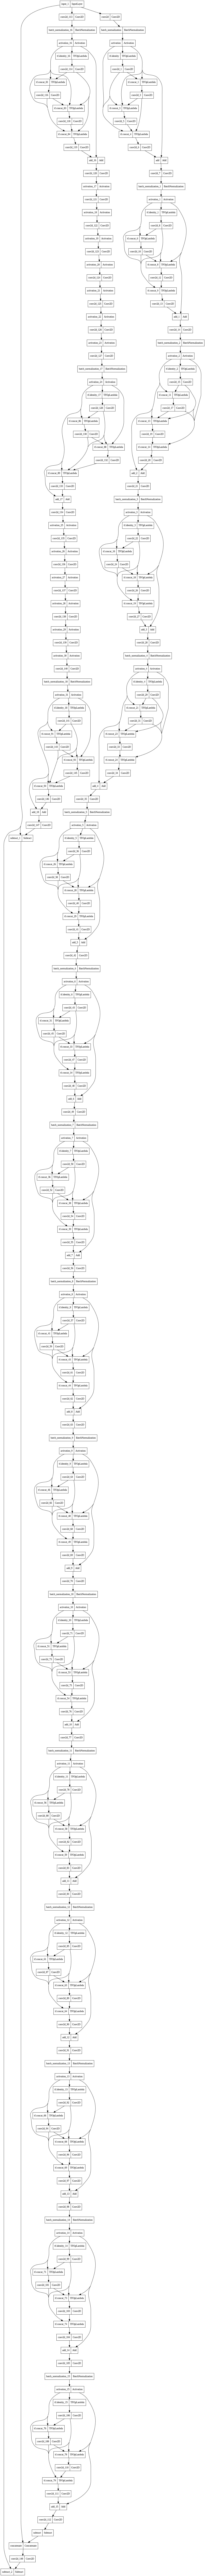

In [ ]:
model = BRDNet(input_shape=input_shape)
plot_model(model, show_shapes=False)

In [ ]:
def adding_noise(x, noise_factor = 0.0002, mean = 0, std = 1):
    x_noisy = x + noise_factor * np.random.normal(loc=mean, scale = std,
                                                  size = x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy


In [ ]:
x_train_noisy = adding_noise(x_train, noise_factor=0.0001, std = 15)
x_test_noisy = adding_noise(x_test, noise_factor=0.0001, std = 15)

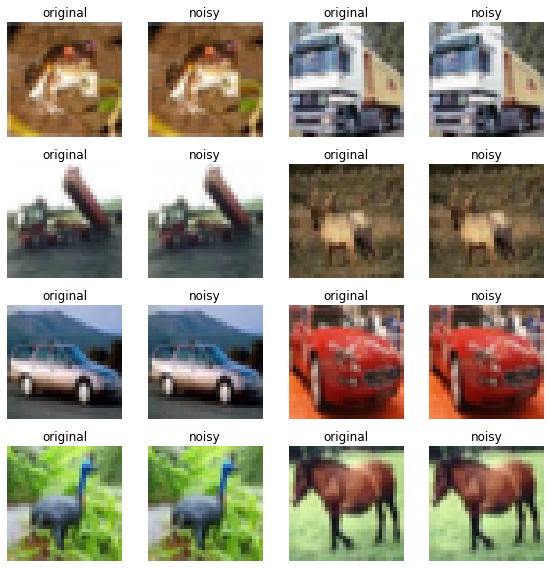

In [ ]:
plt.figure(figsize=(8,8))
ind = 0
for i in range(8):
    plt.subplot(4,4,i+1+ind)
    plt.imshow(x_train[i,:,:,:])
    plt.axis("off")
    plt.title("original")
    ind+=1
    plt.subplot(4,4,i+1+ind)
    plt.imshow(x_train_noisy[i,:,:,:])
    plt.axis("off")
    plt.title("noisy")
plt.tight_layout()

In [ ]:
history = model.fit(x=x_train_noisy, y = x_train,
          epochs=10, verbose=1, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1563/1563 [==============================] - 592s 342ms/step - loss: 0.5531 - val_loss: 0.0038
Epoch 2/10
1563/1563 [==============================] - 545s 349ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 3/10
1563/1563 [==============================] - 535s 342ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 4/10
1563/1563 [==============================] - 533s 341ms/step - loss: nan - val_loss: nan
Epoch 5/10
1563/1563 [==============================] - 518s 331ms/step - loss: nan - val_loss: nan
Epoch 6/10
1563/1563 [==============================] - 531s 339ms/step - loss: nan - val_loss: nan
Epoch 7/10
1563/1563 [==============================] - 530s 339ms/step - loss: nan - val_loss: nan
Epoch 8/10
1563/1563 [==============================] - 517s 331ms/step - loss: nan - val_loss: nan
Epoch 9/10
1563/1563 [==============================] - 518s 331ms/step - loss: nan - val_loss: nan
Epoch 10/10
1563/1563 [==============================] - 532s 340ms/step - loss: n

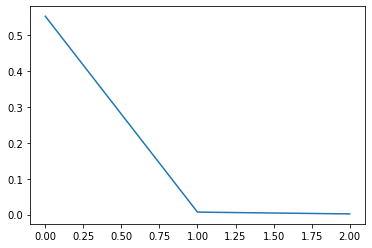

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(np.divide(1,history.history['loss']))
# plt.legend(['mse', 'psnr'])

313/313 [==============================] - 28s 89ms/step


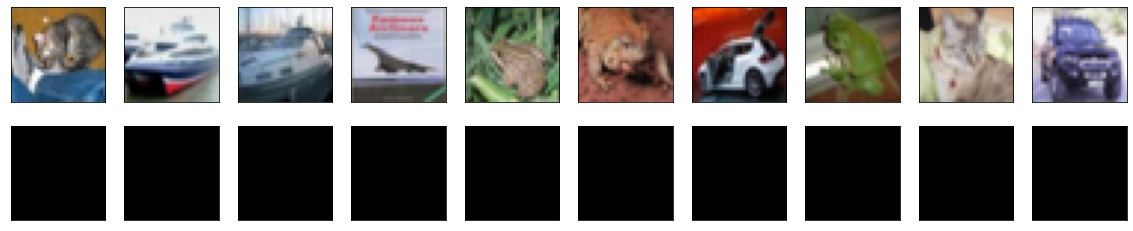

In [ ]:
denoise = model.predict(x_test)

n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(denoise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from skimage import measure, metrics

In [ ]:
mse_skimg = metrics.mean_squared_error(denoise, x_test_noisy)
print("MSE: = ", mse_skimg)


MSE: =  nan


In [ ]:
psnr_skimg = metrics.peak_signal_noise_ratio( x_test_noisy,denoise, data_range=None)
print("PSNR: = ", psnr_skimg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.


PSNR: =  52.88205612046768
